This notebook is final capstone project developed in IBM Data Science Certified Professional course.  

The notebook process New Jersey Neighborhoods with ML and finds neighborhoods with similar characteristics in terms of socio-economic indicator and venues, and offer you vital parameters to enable you to decide on best neighborhood suitable for you for living in the city. New Jersey Neighborhoods geospatial data was collected from several websites and stored in a CSV file. It uses k-means algorithm to segments and clusters Neighborhoods in New Jersey city. The data is plot on map to visualize neighborhoods and how they cluster together.      

In [3]:
import pandas as pd
import numpy as np
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
# we are using the inline backend
%matplotlib inline


Read New Jersey Neighborhoods geospatial data from csv file and load into a dataframe

In [4]:
# The code was removed by Watson Studio for sharing.

,Neighborhood,Latitude,Longitude,Median Apartment Rent,Median Household Income,Total Population,Population Density
0,Bergen-Lafayette,40.711146,-74.074073,1443,43500,21220,18840
1,Downtown,40.728100,-74.077600,3398,87400,29180,18510
2,Greenville,40.698963,-74.095806,1399,45700,47290,23750
3,Hackensack Riverfront,40.830412,-74.040087,2345,142900,3070,3590
4,Journal Square,40.734572,-74.063154,1642,48600,29640,27640
5,Liberty Park,40.747980,-74.058304,2024,139500,1580,860
6,Lincoln Park,40.725394,-74.082687,2250,57200,670,1500
7,McGinley Square,40.724122,-74.069667,2010,37500,18340,33930
8,The Heights,40.751097,-74.053968,3012,57600,55000,32860
9,The Waterfront,40.722029,-74.037356,3047,138600,19140,37110


#### Data Explorartion

we will plot household income, rent and population data and explore effect between statistical parameters per each neighborbood. Pattern emerging out will also show characteristics difference & uniqueness of each neighborhood.   

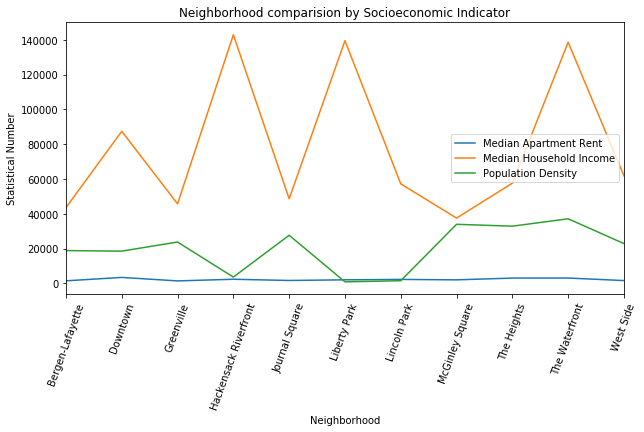

In [5]:
#Step 2: Plot the dataframe. To make the plot more readeable, we will change the size using the `figsize` parameter.
df_Neighborhood_plot =  df_Neighborhood [['Neighborhood', 'Median Apartment Rent','Median Household Income','Population Density']]

df_Neighborhood_plot.set_index('Neighborhood',inplace = True) # let's change the index values to Neighborhood names for plotting


ax = df_Neighborhood_plot.plot(kind='line', use_index=True, rot=0, figsize=[10,5])
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10]) 

ax.set_xticklabels(['Bergen-Lafayette','Downtown', 'Greenville','Hackensack Riverfront','Journal Square','Liberty Park','Lincoln Park','McGinley Square','The Heights','The Waterfront','West Side'], rotation=70)
plt.title('Neighborhood comparision by Socioeconomic Indicator')
plt.ylabel('Statistical Number')
plt.xlabel('Neighborhood')

plt.show()



/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[

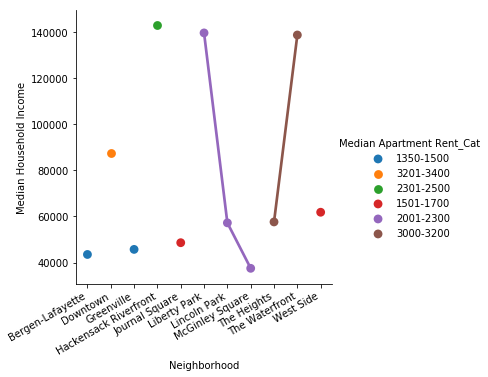

In [6]:
import seaborn as sns
df_Neighborhood_plot.reset_index(inplace=True)

df_Neighborhood_plot = df_Neighborhood_plot[['Neighborhood','Median Apartment Rent','Median Household Income','Population Density']]
df_Neighborhood_plot['Median Apartment Rent_Cat']= ''
for index, neigh in df_Neighborhood_plot.iterrows():
    
    neigh_rent = pd.to_numeric(neigh[['Median Apartment Rent']].values)
    
    if neigh_rent >=1350 and neigh_rent <=1500:
        df_Neighborhood_plot.set_value(index,'Median Apartment Rent_Cat','1350-1500')
    if neigh_rent >=1501 and neigh_rent <=1700:
        df_Neighborhood_plot.set_value(index,'Median Apartment Rent_Cat', '1501-1700')
    if neigh_rent >=1701 and neigh_rent <=2000:
        df_Neighborhood_plot.set_value(index,'Median Apartment Rent_Cat', '1701-2000')   
    if neigh_rent >=2001 and neigh_rent <=2300:
        df_Neighborhood_plot.set_value(index,'Median Apartment Rent_Cat', '2001-2300') 
    if neigh_rent >=2301 and neigh_rent <=2500:
        df_Neighborhood_plot.set_value(index,'Median Apartment Rent_Cat', '2301-2500')     
    if neigh_rent >=3000 and neigh_rent <=3200:
        df_Neighborhood_plot.set_value(index,'Median Apartment Rent_Cat', '3000-3200') 
    if neigh_rent >=3201 and neigh_rent <=3400:
        df_Neighborhood_plot.set_value(index,'Median Apartment Rent_Cat', '3201-3400')    

ax = sns.catplot(x='Neighborhood',y= 'Median Household Income',hue='Median Apartment Rent_Cat', kind='point',data=df_Neighborhood_plot)
ax.fig.autofmt_xdate()

We will use the Foursquare API to explore neighborhoods in New Jersey City and the explore function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. We will use the k-means clustering algorithm to complete this task. Finally, we will use the Folium library to visualize the neighborhoods in Jersey City and their emerging clusters.

In [7]:
#check how many neighborhoods the dataset has
print('The dataframe has {} neighborhoods.'.format(     
        df_Neighborhood.shape[0]
    )
)

The dataframe has 11 neighborhoods.


We will create a map of New Jersey City with neighborhoods superimposed on top. for that first we will use geopy library and get the latitude and longitude values of Toronto.

In [8]:
#get the latitude and longitude values of Toronto
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Jersey City, New Jersey'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Jersey City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Jersey City are 40.7281575, -74.0776417.


In [1]:
#Install folium library

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.3 MB

The following NEW packages will be 

In [9]:

import folium # map rendering library

# create map of Jersey City using latitude and longitude values
map_jerseycity = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(df_Neighborhood['Latitude'], df_Neighborhood['Longitude'], df_Neighborhood['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_jerseycity)  
    
map_jerseycity

Next, we are going to utiliz the Foursquare API to explore the neighborhoods and segment them.

In [12]:
#Define Foursquare Credentials and Version

CLIENT_ID = 'XXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

## Explore Neighborhoods in Jersey City

Let's create a function to get the top 100 venues that are within a radius of 500 meters of a neighborhood. we will run same function for all the neighborhoods in Jersey City

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
#Get venues for all neighborhoods in our dataset
jerseycity_venues = getNearbyVenues(names=df_Neighborhood['Neighborhood'],
                                latitudes=df_Neighborhood['Latitude'],
                                longitudes=df_Neighborhood['Longitude'])

Bergen-Lafayette
Downtown
Greenville
Hackensack Riverfront
Journal Square
Liberty Park
Lincoln Park
McGinley Square
The Heights
The Waterfront
West Side


In [14]:
#Check size of resulting dataframe
jerseycity_venues.shape

(212, 7)

In [15]:
jerseycity_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bergen-Lafayette,40.711146,-74.074073,Light Rail Café,40.709155,-74.073795,Café
1,Bergen-Lafayette,40.711146,-74.074073,Family Dollar,40.711119,-74.076821,Discount Store
2,Bergen-Lafayette,40.711146,-74.074073,Dunkin',40.710842,-74.079287,Donut Shop
3,Bergen-Lafayette,40.711146,-74.074073,Berry Lane Park,40.711049,-74.070129,Park
4,Bergen-Lafayette,40.711146,-74.074073,Arlington Park,40.712304,-74.072607,Park


In [16]:
#Number of venues per neighborhood
jerseycity_venues.groupby('Neighborhood').count()


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bergen-Lafayette,11,11,11,11,11,11
Downtown,13,13,13,13,13,13
Greenville,11,11,11,11,11,11
Hackensack Riverfront,1,1,1,1,1,1
Journal Square,74,74,74,74,74,74
Liberty Park,13,13,13,13,13,13
Lincoln Park,7,7,7,7,7,7
McGinley Square,23,23,23,23,23,23
The Heights,7,7,7,7,7,7


### Analyze Each Neighborhood

In [17]:
# one hot encoding
jerseycity_onehot = pd.get_dummies(jerseycity_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
jerseycity_onehot['Neighborhood'] = jerseycity_venues['Neighborhood'] 


# move neighborhood column to the first column
fixed_columns = [jerseycity_onehot.columns[-1]] + list(jerseycity_onehot.columns[:-1])
jerseycity_onehot = jerseycity_onehot[fixed_columns]

jerseycity_onehot.head()

,Neighborhood,American Restaurant,Auto Garage,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Beer Garden,Boxing Gym,...,Sporting Goods Shop,Steakhouse,Supermarket,Tennis Court,Thai Restaurant,Thrift / Vintage Store,Track,Video Game Store,Waterfront,Yoga Studio
0,Bergen-Lafayette,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bergen-Lafayette,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bergen-Lafayette,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bergen-Lafayette,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bergen-Lafayette,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# get new dataframe size
jerseycity_onehot.shape

(212, 89)

Let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [19]:
jerseycity_grouped = jerseycity_onehot.groupby('Neighborhood').mean().reset_index()
jerseycity_grouped

,Neighborhood,American Restaurant,Auto Garage,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Beer Garden,Boxing Gym,...,Sporting Goods Shop,Steakhouse,Supermarket,Tennis Court,Thai Restaurant,Thrift / Vintage Store,Track,Video Game Store,Waterfront,Yoga Studio
0,Bergen-Lafayette,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Downtown,0.076923,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Greenville,0.000000,0.090909,0.000000,0.090909,0.000000,0.000000,0.090909,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Hackensack Riverfront,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Journal Square,0.013514,0.000000,0.013514,0.027027,0.013514,0.000000,0.000000,0.000000,0.000000,...,0.013514,0.000000,0.000000,0.000000,0.013514,0.013514,0.000000,0.000000,0.000000,0.013514
5,Liberty Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Lincoln Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000
7,McGinley Square,0.043478,0.000000,0.043478,0.000000,0.000000,0.086957,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,The Heights,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,The Waterfront,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,0.020833,...,0.000000,0.020833,0.000000,0.000000,0.000000,0.000000,0.000000,0.020833,0.020833,0.020833


In [20]:
jerseycity_grouped.shape

(11, 89)

Let's print each neighborhood along with the top 5 most common venues

In [21]:
num_top_venues = 5

for hood in jerseycity_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = jerseycity_grouped[jerseycity_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bergen-Lafayette----
                venue  freq
0                Park  0.18
1  Light Rail Station  0.09
2      Discount Store  0.09
3      Cosmetics Shop  0.09
4          Donut Shop  0.09


----Downtown----
                  venue  freq
0   American Restaurant  0.08
1        Breakfast Spot  0.08
2  Fast Food Restaurant  0.08
3          College Quad  0.08
4           Coffee Shop  0.08


----Greenville----
             venue  freq
0         Pharmacy  0.09
1  Bed & Breakfast  0.09
2         Bus Line  0.09
3        Gift Shop  0.09
4              Gym  0.09


----Hackensack Riverfront----
                     venue  freq
0              Coffee Shop   1.0
1      American Restaurant   0.0
2                 Pharmacy   0.0
3     Other Great Outdoors   0.0
4  North Indian Restaurant   0.0


----Journal Square----
                  venue  freq
0     Indian Restaurant  0.27
1         Grocery Store  0.05
2   Fried Chicken Joint  0.04
3  Fast Food Restaurant  0.04
4                  Café  0.04




Let's create a dataframe for these data

In [22]:
# function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
jerseycity_venues_sorted = pd.DataFrame(columns=columns)
jerseycity_venues_sorted['Neighborhood'] = jerseycity_grouped['Neighborhood']


for ind in np.arange(jerseycity_grouped.shape[0]):
    jerseycity_venues_sorted.iloc[ind, 1:] = return_most_common_venues(jerseycity_grouped.iloc[ind, :], num_top_venues)

jerseycity_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bergen-Lafayette,Park,Seafood Restaurant,Food,Light Rail Station,Café,Discount Store,Donut Shop,Fast Food Restaurant,Cosmetics Shop,Supermarket
1,Downtown,American Restaurant,Pizza Place,Fruit & Vegetable Store,Filipino Restaurant,Fast Food Restaurant,Korean Restaurant,Latin American Restaurant,Grocery Store,Park,Coffee Shop
2,Greenville,Gym,Bed & Breakfast,Gift Shop,Pharmacy,Pizza Place,Italian Restaurant,Salon / Barbershop,Bus Line,Deli / Bodega,Auto Garage
3,Hackensack Riverfront,Coffee Shop,Yoga Studio,Cosmetics Shop,Deli / Bodega,Department Store,Diner,Discount Store,Dive Bar,Donut Shop,Farmers Market
4,Journal Square,Indian Restaurant,Grocery Store,Fast Food Restaurant,Café,Coffee Shop,Pizza Place,Fried Chicken Joint,Bakery,Convenience Store,Pharmacy


In [24]:
# Add Household income, rent and neighborhood population in dataset for clustering

   
from sklearn.preprocessing import StandardScaler

#jerseycity_statistics= df_Neighborhood[['Neighborhood','Median Apartment Rent','Median Household Income','Population Density']]
jerseycity_statistics= df_Neighborhood[['Neighborhood','Median Household Income','Population Density']]

jerseycity_grouped_clustering = jerseycity_statistics.join(jerseycity_grouped.set_index('Neighborhood'), on='Neighborhood') 
#jerseycity_grouped_clustering.head()
jerseycity_grouped_clustering = jerseycity_grouped_clustering.drop('Neighborhood', 1)


scaled_features = StandardScaler().fit_transform(jerseycity_grouped_clustering.values)

scaled_features

array([[-0.86763142, -0.10341615, -0.63623247, -0.31622777, -0.40755583,
        -0.54881683, -0.31622777, -0.47032837, -0.31622777, -0.31622777,
        -0.31622777, -0.47140452, -0.31622777, -0.39807261, -0.31622777,
        -0.31622777,  2.03538132, -0.31622777, -0.31622777, -0.43929386,
        -0.31622777, -0.4078276 , -0.31622777, -0.41640649,  3.16227766,
        -0.31622777, -0.45779154, -0.34425764, -0.31622777,  3.12722925,
        -0.31622777,  0.87718942, -0.4790503 ,  1.17901727, -0.37257819,
         3.16227766, -0.31622777, -0.31622777, -0.31622777, -0.31622777,
        -0.31622777, -0.31622777, -0.31622777, -0.54026481, -0.53590757,
        -0.31622777, -0.31622777, -0.31622777, -0.36864065, -0.31622777,
        -0.55008864, -0.34222879, -0.31622777, -0.57654447, -0.31622777,
        -0.31622777, -0.31622777, -0.31622777, -0.4790503 ,  3.16227766,
        -0.31622777, -0.38392886, -0.31622777, -0.31622777, -0.31622777,
        -0.31622777, -0.31622777,  2.18062064, -0.5

## Cluster Neighborhoods

Run k-means to cluster the neighborhood into 5 clusters.

In [25]:
from sklearn.cluster import KMeans # import k-means from clustering stage

# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(scaled_features)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 1, 1, 1, 0, 1, 1, 4, 1, 3, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [26]:
# add clustering labels
#jerseycity_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
jerseycity_venues_sorted['Cluster Labels'] = kmeans.labels_
jerseycity_merged = df_Neighborhood

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
jerseycity_merged = jerseycity_merged.join(jerseycity_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

jerseycity_merged.head() 

,Neighborhood,Latitude,Longitude,Median Apartment Rent,Median Household Income,Total Population,Population Density,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Bergen-Lafayette,40.711146,-74.074073,1443,43500,21220,18840,Park,Seafood Restaurant,Food,Light Rail Station,Café,Discount Store,Donut Shop,Fast Food Restaurant,Cosmetics Shop,Supermarket,2
1,Downtown,40.728100,-74.077600,3398,87400,29180,18510,American Restaurant,Pizza Place,Fruit & Vegetable Store,Filipino Restaurant,Fast Food Restaurant,Korean Restaurant,Latin American Restaurant,Grocery Store,Park,Coffee Shop,1
2,Greenville,40.698963,-74.095806,1399,45700,47290,23750,Gym,Bed & Breakfast,Gift Shop,Pharmacy,Pizza Place,Italian Restaurant,Salon / Barbershop,Bus Line,Deli / Bodega,Auto Garage,1
3,Hackensack Riverfront,40.830412,-74.040087,2345,142900,3070,3590,Coffee Shop,Yoga Studio,Cosmetics Shop,Deli / Bodega,Department Store,Diner,Discount Store,Dive Bar,Donut Shop,Farmers Market,1
4,Journal Square,40.734572,-74.063154,1642,48600,29640,27640,Indian Restaurant,Grocery Store,Fast Food Restaurant,Café,Coffee Shop,Pizza Place,Fried Chicken Joint,Bakery,Convenience Store,Pharmacy,0


Let's visualize the resulting clusters

In [27]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Create Choropleth map of jersey city neighborhoods and superimpose cluster information on it.
# Fetch the file
#geojson_file = project.get_file_url("jersey_city_neighborhoods.geojson")

#map_clusters.choropleth(
#    geo_data=geojson_file,
#    data=jerseycity_merged,
#    columns=['Neighborhood', 'Median Household Income'],
#    key_on='feature.properties.name',
#    fill_color='YlOrRd', 
#    fill_opacity=0.7, 
#    line_opacity=0.2,
#    legend_name='Median Household Income in Jersey City'
#)

# display map
map_clusters

Let's superimpose clusters information on the map

In [28]:
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(jerseycity_merged['Latitude'], jerseycity_merged['Longitude'], jerseycity_merged['Neighborhood'], jerseycity_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

Cluster 1

In [29]:
jerseycity_merged.loc[jerseycity_merged['Cluster Labels'] == 0, jerseycity_merged.columns[[0] + list(range(3, jerseycity_merged.shape[1]))]]

,Neighborhood,Median Apartment Rent,Median Household Income,Total Population,Population Density,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
4,Journal Square,1642,48600,29640,27640,Indian Restaurant,Grocery Store,Fast Food Restaurant,Café,Coffee Shop,Pizza Place,Fried Chicken Joint,Bakery,Convenience Store,Pharmacy,0


Cluster 2

In [30]:
jerseycity_merged.loc[jerseycity_merged['Cluster Labels'] == 1, jerseycity_merged.columns[[0] + list(range(3, jerseycity_merged.shape[1]))]]

,Neighborhood,Median Apartment Rent,Median Household Income,Total Population,Population Density,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
1,Downtown,3398,87400,29180,18510,American Restaurant,Pizza Place,Fruit & Vegetable Store,Filipino Restaurant,Fast Food Restaurant,Korean Restaurant,Latin American Restaurant,Grocery Store,Park,Coffee Shop,1
2,Greenville,1399,45700,47290,23750,Gym,Bed & Breakfast,Gift Shop,Pharmacy,Pizza Place,Italian Restaurant,Salon / Barbershop,Bus Line,Deli / Bodega,Auto Garage,1
3,Hackensack Riverfront,2345,142900,3070,3590,Coffee Shop,Yoga Studio,Cosmetics Shop,Deli / Bodega,Department Store,Diner,Discount Store,Dive Bar,Donut Shop,Farmers Market,1
5,Liberty Park,2024,139500,1580,860,Donut Shop,Motel,Convenience Store,Park,Bar,Pharmacy,Breakfast Spot,Burger Joint,Dive Bar,Farmers Market,1
6,Lincoln Park,2250,57200,670,1500,Fast Food Restaurant,Gym,Track,Park,Tennis Court,Latin American Restaurant,Rental Car Location,Donut Shop,Cycle Studio,Deli / Bodega,1
8,The Heights,3012,57600,55000,32860,Farmers Market,Donut Shop,Miscellaneous Shop,Pizza Place,Deli / Bodega,IT Services,Restaurant,Cycle Studio,Department Store,Diner,1
10,West Side,1586,61800,22490,22850,Track,General Travel,Department Store,Lake,Yoga Studio,Farmers Market,Cycle Studio,Deli / Bodega,Diner,Discount Store,1


Cluster 3

In [31]:
jerseycity_merged.loc[jerseycity_merged['Cluster Labels'] == 2, jerseycity_merged.columns[[0] + list(range(3, jerseycity_merged.shape[1]))]]

,Neighborhood,Median Apartment Rent,Median Household Income,Total Population,Population Density,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Bergen-Lafayette,1443,43500,21220,18840,Park,Seafood Restaurant,Food,Light Rail Station,Café,Discount Store,Donut Shop,Fast Food Restaurant,Cosmetics Shop,Supermarket,2


Cluster 4

In [32]:
jerseycity_merged.loc[jerseycity_merged['Cluster Labels'] == 3, jerseycity_merged.columns[[0] + list(range(3, jerseycity_merged.shape[1]))]]

,Neighborhood,Median Apartment Rent,Median Household Income,Total Population,Population Density,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
9,The Waterfront,3047,138600,19140,37110,Coffee Shop,Hotel,Gym / Fitness Center,Mexican Restaurant,Sandwich Place,Beer Garden,Ice Cream Shop,Italian Restaurant,American Restaurant,Yoga Studio,3


Cluster 5

In [33]:
jerseycity_merged.loc[jerseycity_merged['Cluster Labels'] == 4, jerseycity_merged.columns[[0] + list(range(3, jerseycity_merged.shape[1]))]]  

,Neighborhood,Median Apartment Rent,Median Household Income,Total Population,Population Density,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
7,McGinley Square,2010,37500,18340,33930,Sandwich Place,Café,Italian Restaurant,Bar,American Restaurant,General Entertainment,Ice Cream Shop,Fast Food Restaurant,Jazz Club,Donut Shop,4
